In [306]:
#import statements 
%matplotlib inline
import os

import numpy as np
import pandas as pd
import seaborn as sns

from nba_utils import draw_3pt_piechart,plot_shot_chart,draw_court
from array import array
from IPython.core.display import display, HTML
from IPython.core.magic import register_cell_magic, register_line_cell_magic, register_line_magic
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

sns.set_style("white")
sns.set_color_codes()

In [307]:
#Plot settings 
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 9
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 18

# for export purposes only
display(HTML('<style>.container {width:80% !important;}</style>'))
update_title = 'document.title = "Using Python to Analyze the NBA and the 3-point Shot";'
HTML('<script>{}</script>'.format(update_title))

In [308]:
df = pd.read_csv('data/season_totals.csv')
df.sort_values('pts',ascending=False).head(10)[['yr','player','age','pts','fg3','mp']]

,yr,player,age,pts,fg3,mp
2728,1987,"Jordan,Michael",23,3041,12,3281
3126,1988,"Jordan,Michael",24,2868,7,3311
11963,2006,"Bryant,Kobe",27,2832,180,3277
4000,1990,"Jordan,Michael",26,2753,92,3197
3552,1989,"Jordan,Michael",25,2633,27,3255
16643,2014,"Durant,Kevin",25,2593,192,3122
121,1980,"Gervin,George",27,2585,32,2934
4463,1991,"Jordan,Michael",27,2580,29,3034
826,1982,"Gervin,George",29,2551,10,2817
5353,1993,"Jordan,Michael",29,2541,81,3067


In [310]:
df.columns

Index(['Unnamed: 0', 'player', 'pos', 'age', 'team_id', 'g', 'gs', 'mp', 'fg',
       'fga', 'fg_pct', 'fg3', 'fg3a', 'fg3_pct', 'fg2', 'fg2a', 'fg2_pct',
       'efg_pct', 'ft', 'fta', 'ft_pct', 'orb', 'drb', 'trb', 'ast', 'stl',
       'blk', 'tov', 'pf', 'pts', 'yr'],
      dtype='object')

In [311]:
#query for number of minutes played in each year wrt number of 3 pointer attempts.
res= df.sort_values('yr',ascending=False).groupby('yr').agg({'mp' : 'sum', 'fg3a' : 'sum'})
res['fg3a_p36m'] = 36*res['fg3a']/res['mp']
res.reset_index(level=0, inplace=True)
res.head()

,yr,mp,fg3a,fg3a_p36m
0,1980,484753,5522,0.410089
1,1981,483373,4154,0.309376
2,1982,490701,4655,0.341511
3,1983,498711,4592,0.331479
4,1984,463017,4593,0.357110


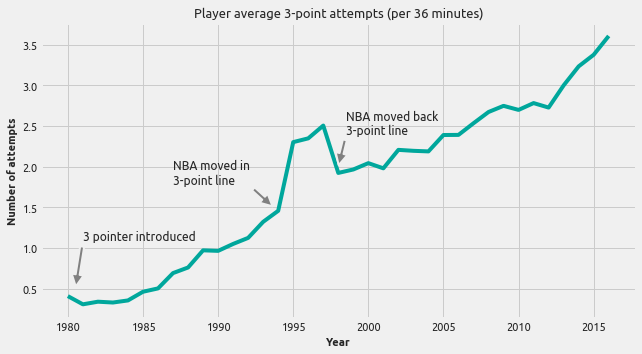

In [312]:
#graph demonstrating the number of avg. attempts by a player
plt.plot(res.yr,res.fg3a_p36m, color = '#00a79c')
plt.xlabel('Year')
plt.ylabel('Number of attempts')
_=plt.title('Player average 3-point attempts (per 36 minutes)')
_=plt.annotate('3 pointer introduced', xy=(1980.5, .5), xytext=(1981, 1.1), fontsize = 12,
               arrowprops=dict(facecolor='grey', shrink=0.05, linewidth = 2))
_=plt.annotate('NBA moved in\n3-point line', xy=(1993.7, 1.5), xytext=(1987, 1.79), fontsize = 12,
               arrowprops=dict(facecolor='grey', shrink=0.05, linewidth = 2))
_=plt.annotate('NBA moved back\n3-point line', xy=(1998, 2.), xytext=(1998.5, 2.4), fontsize = 12,
               arrowprops=dict(facecolor='grey', shrink=0.05, linewidth = 2))
plt.tight_layout()
plt.savefig('results/3_point_trend.png')

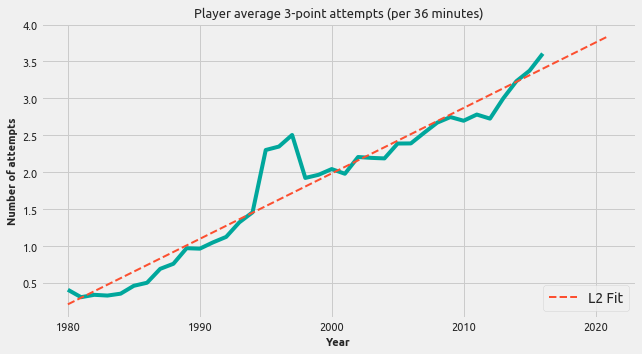

In [313]:
#Linear Regression Model
X = res['yr'].values.reshape(-1, 1) 
Y = res['fg3a_p36m'].values.reshape(-1,1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)
prediction_yrs = np.array([[2017], [2018], [2019], [2020], [2021]])
all_yrs = np.concatenate((X,prediction_yrs))
Y_pred = linear_regressor.predict(all_yrs)
plt.plot(X, Y, color = '#00a79c', label = None)
plt.plot(all_yrs, Y_pred,linewidth = 2, linestyle = '--',color = '#fc4f30', label = 'L2 Fit')
plt.xlabel('Year')
plt.ylabel('Number of attempts')
plt.legend(loc = 4)
_=plt.title('Player average 3-point attempts (per 36 minutes)')
plt.tight_layout()
plt.show()

In [314]:
# reset style for pretty shot charts
plt.style.use('default')
sns.set_style("white")
df = pd.read_csv('data/shot_charts_top_10/1000_plus_shot_charts_2011_2016.csv')
res = df.sort_values('game_date',ascending = True)[['yr','name','game_date','shot_distance','x','y','shot_made_flag']]

res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243719 entries, 32851 to 232463
Data columns (total 7 columns):
yr                243719 non-null int64
name              243719 non-null object
game_date         243719 non-null object
shot_distance     243719 non-null int64
x                 243719 non-null int64
y                 243719 non-null int64
shot_made_flag    243719 non-null int64
dtypes: int64(5), object(2)
memory usage: 14.9+ MB


In [315]:
def is_corner_3(x,y):
    return int((abs(x) >= 220) and (y < 92.5))

def is_normal_3(x,y,corner3):
    radius = 475/2
    y_3pt = np.sqrt(np.square(radius) - np.square(x))
    return int(y > max(92.5,y_3pt) and not corner3)


def is_a_3_ptr(x,y):
    '''Want to identify 3 pointers, maybe corner or normal attempts'''
    corner3 = is_corner_3(x,y)
    normal3 = is_normal_3(x,y,corner3)
    return corner3 + normal3

res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243719 entries, 32851 to 232463
Data columns (total 7 columns):
yr                243719 non-null int64
name              243719 non-null object
game_date         243719 non-null object
shot_distance     243719 non-null int64
x                 243719 non-null int64
y                 243719 non-null int64
shot_made_flag    243719 non-null int64
dtypes: int64(5), object(2)
memory usage: 14.9+ MB


In [316]:
#solution = is_a_3_ptr(186,175)
x_coord_arr = res['x'].to_numpy()
y_coord_arr = res['y'].to_numpy()
n = len(x_coord_arr)
for i in range(0,n):
    result = (is_a_3_ptr(x_coord_arr[i],y_coord_arr[i]))
    res.at[i+32851, 'is_a_corner_3'] = int(is_corner_3(x_coord_arr[i],y_coord_arr[i]))
    res.at[i+32851,'is_normal_3'] = int(is_normal_3(x_coord_arr[i],y_coord_arr[i],0))
    res.at[i+32851, 'is_a_3_ptr'] = int(result)
    

In [317]:
#so we have the type of 3 pointers sorted.
res.head()

,yr,name,game_date,shot_distance,x,y,shot_made_flag,is_a_corner_3,is_normal_3,is_a_3_ptr
32851,2011.0,Luis Scola,2010-10-26,5.0,51.0,7.0,0.0,0.0,0.0,0.0
32852,2011.0,Luis Scola,2010-10-26,19.0,86.0,175.0,0.0,0.0,0.0,0.0
32853,2011.0,Luis Scola,2010-10-26,17.0,-37.0,170.0,1.0,0.0,0.0,0.0
32854,2011.0,Luis Scola,2010-10-26,16.0,-166.0,-2.0,0.0,0.0,0.0,0.0
32855,2011.0,Luis Scola,2010-10-26,4.0,34.0,26.0,0.0,0.0,0.0,0.0


In [318]:
#print(res[res['is_a_3_ptr']==1.0]['is_a_3_ptr'])
res = res.fillna(0)
res = res.astype({'yr':'int64','x':'int64','y':'int64','is_a_3_ptr':'int64','is_a_corner_3':'int64','is_normal_3':'int64','shot_made_flag':'int64'})
res.head()


,yr,name,game_date,shot_distance,x,y,shot_made_flag,is_a_corner_3,is_normal_3,is_a_3_ptr
32851,2011,Luis Scola,2010-10-26,5.0,51,7,0,0,0,0
32852,2011,Luis Scola,2010-10-26,19.0,86,175,0,0,0,0
32853,2011,Luis Scola,2010-10-26,17.0,-37,170,1,0,0,0
32854,2011,Luis Scola,2010-10-26,16.0,-166,-2,0,0,0,0
32855,2011,Luis Scola,2010-10-26,4.0,34,26,0,0,0,0


In [319]:
#validating the query before applying 
res.query('yr==2011')['is_a_3_ptr'].mean()

0.05384473538631754

In [324]:
#Year-wise analysis of shot variations using heat map and pie chart.
year_val = 2011
for year_val in range(2011,2017):
    data_x = res[res['yr']==year_val]['x']
    data_y = res[res['yr']==year_val]['y']
    x = data_x.to_numpy()
    y = data_y.to_numpy()
    # make shot charts for all years
    midrange_thresh = 8
    yr = year_val
    in_half_court = 'y <= 400 and abs(x) <= 250' 
    addl_filter = 'shot_distance > {midrange_thresh}'.format(midrange_thresh = midrange_thresh)
    df_yr = res.filter('''{in_half_court} and yr == {yr} and {addl_filter}'''.format(in_half_court = in_half_court,yr = yr,addl_filter = addl_filter))
    #Ground heat map
    kind = 'hex'
    gridsize = 15
    label = ''.format((year_val))
    title = ''
    norm = None
    cmap=plt.cm.gist_heat_r
    joint_shot_chart = sns.jointplot(x,y,stat_func=None,kind=kind, space=0, color=cmap(.2), cmap=cmap, size = 20, joint_kws=dict(gridsize=gridsize, norm = norm))
    joint_shot_chart.fig.set_size_inches(9,8.25)
    if kind == 'hex':# color bar
        cax = joint_shot_chart.fig.add_axes([.77, .04, .03, .2]) # size and placement of bar
        plt.colorbar(cax=cax)
    
# A joint plot has 3 Axes, the first one called ax_joint 
# is the one we want to draw our court onto 
    ax = joint_shot_chart.ax_joint
    draw_court(ax)

# Adjust the axis limits and orientation of the plot in order
# to plot half court, with the hoop by the top of the plot
    ax.set_xlim(-250,250)
    ax.set_ylim(422.5, -47.5)

# Get rid of axis labels and tick marks
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(labelbottom='off', labelleft='off')
# label
    ax.text(-200,405,label, fontsize=20)
    joint_shot_chart.fig.suptitle('Evolution of the 3 point shot - {}'.format(year_val), x = .19, y = 0.86, size = 20, fontweight= 'bold')

#pie chart creation 
    per_3 = res[res['yr']==year_val]['is_a_3_ptr'].mean()
    per_midrange = 1 - per_3
    plt.axes([.05, .1, .2, .2],facecolor='#E6E6E6')
    patches,_ = plt.pie(x = [per_3,per_midrange],startangle = 180,counterclock = False)
    labels = ['3 pointer','midrange']
#colors = ['red', 'orange']
    sns_colors = sns.color_palette('GnBu_d')
    colors = [sns_colors[1], sns_colors[4]]
    patches,_ = plt.pie(x = [per_3,per_midrange],startangle = 180, colors = colors,counterclock = False)
    plt.legend(patches, labels, loc=3 ,shadow=True, fontsize='large', frameon = True) 
    plt.title('Percentage of shots in', y = -0.08)
    
    joint_shot_chart.savefig('results/all_years/{}.png'.format(yr))
    plt.close()
    

In [ ]:
#store the years analysis images as gif
!convert -delay 200 -loop 0 results/all_years/*.png results/evolution_3pt.gif

In [327]:
shot_acc = res.copy()
shot_acc.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 276570 entries, 32851 to 276569
Data columns (total 10 columns):
yr                276570 non-null int64
name              276570 non-null object
game_date         276570 non-null object
shot_distance     276570 non-null float64
x                 276570 non-null int64
y                 276570 non-null int64
shot_made_flag    276570 non-null int64
is_a_corner_3     276570 non-null int64
is_normal_3       276570 non-null int64
is_a_3_ptr        276570 non-null int64
dtypes: float64(1), int64(7), object(2)
memory usage: 23.2+ MB


In [336]:
#Identify the rows which have year = 0. These need to be dropped.
shot_acc[shot_acc['yr']==0]


,yr,name,game_date,shot_distance,x,y,shot_made_flag,is_a_corner_3,is_normal_3,is_a_3_ptr,shot_accuracy
243719,0,0,0,0.0,0,0,0,0,0,0,1
243720,0,0,0,0.0,0,0,0,0,0,0,1
243721,0,0,0,0.0,0,0,0,0,0,0,1
243722,0,0,0,0.0,0,0,0,0,0,0,1
243723,0,0,0,0.0,0,0,0,1,0,1,1
243724,0,0,0,0.0,0,0,0,0,0,0,1
243725,0,0,0,0.0,0,0,0,0,0,0,1
243726,0,0,0,0.0,0,0,0,0,1,1,1
243727,0,0,0,0.0,0,0,0,0,0,0,1
243728,0,0,0,0.0,0,0,0,0,0,0,1


In [337]:
#drop the rows which dont have years and verify it.
shot_acc = shot_acc[shot_acc.yr != 0]
shot_acc['yr'].unique()


array([2011, 2012, 2013, 2014, 2015, 2016])

In [339]:
#We dont need the player name ; Also the game_date field is not needed now since we are working on yearly analysis alone.
shot_acc.drop(['name','game_date'], axis=1)

,yr,shot_distance,x,y,shot_made_flag,is_a_corner_3,is_normal_3,is_a_3_ptr,shot_accuracy
32851,2011,5.0,51,7,0,0,0,0,1
32852,2011,19.0,86,175,0,0,0,0,1
32853,2011,17.0,-37,170,1,0,0,0,1
32854,2011,16.0,-166,-2,0,0,0,0,1
32855,2011,4.0,34,26,0,0,0,0,1
32856,2011,9.0,99,9,0,0,0,0,1
32857,2011,12.0,-128,19,0,0,0,0,1
33385,2011,2.0,12,19,0,0,0,0,1
46872,2011,1.0,-16,11,1,0,0,0,1
46942,2011,2.0,-19,17,0,0,0,0,1


In [353]:
#Comparing the average shot distances of 3 pointer shots alone by each year.
avg_shot_dist_by_year = []
year = [2011,2012,2013,2014,2015,2016]
for year_val in year:
    avg_shot_dist_by_year.append(shot_acc[shot_acc.yr == year_val]['shot_distance'].mean())
avg_shot_dist_by_year

[11.400304414003044,
 11.965594614809275,
 12.386267527264634,
 13.036706998037934,
 12.543267695582756,
 12.982389539175367]

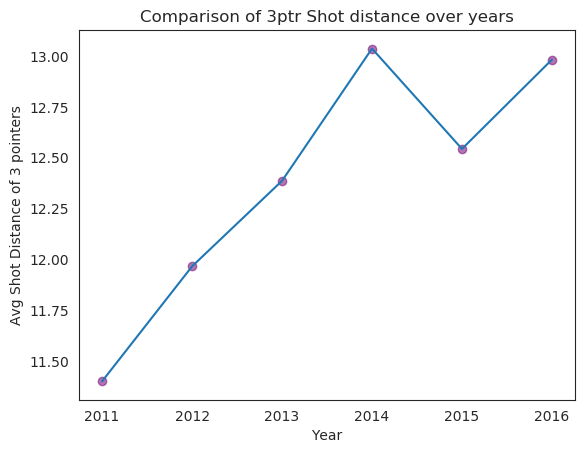

In [390]:
# scatter plot visualization.
plt.scatter(year, avg_shot_dist_by_year,color = (0.5,0.1,0.5,0.6)) 
plt.plot(year, avg_shot_dist_by_year)
plt.xlabel('Year')
plt.ylabel('Avg Shot Distance of 3 pointers')
plt.title('Comparison of 3ptr Shot distance over years')
plt.show() 



In [377]:
#Analysis of 3 pointer shot_accuracy in different years - Assigning metric scores.
for i in range(2011,2017):
#A normal 3 pointer is given score 3.
    mask = (shot_acc['yr'] == i) & (shot_acc['is_normal_3'] != 0)
    shot_acc['shot_accuracy'][mask] = 3
# A corner 3 pointer involves both accuracy and distance, and hence we give tat a score of 5.
    mask = (shot_acc['yr'] == i) & (shot_acc['is_a_corner_3'] != 0)
    shot_acc['shot_accuracy'][mask] = 5

In [378]:
#All the 3 pointers classified based on the metric
shot_acc.query('shot_accuracy ==3 or shot_accuracy == 5')

,yr,name,game_date,shot_distance,x,y,shot_made_flag,is_a_corner_3,is_normal_3,is_a_3_ptr,shot_accuracy
33669,2011,Luis Scola,2010-10-26,1.0,-4,14,0,1,0,1,5
46233,2011,Kevin Martin,2010-10-26,4.0,37,31,0,0,1,1,3
46234,2011,Kevin Martin,2010-10-26,24.0,-146,197,0,0,1,1,3
37708,2011,Chris Bosh,2010-10-26,10.0,100,12,0,0,1,1,3
37871,2011,Dwyane Wade,2010-10-26,0.0,0,6,1,0,1,1,3
38252,2011,Dwyane Wade,2010-10-26,17.0,105,145,0,0,1,1,3
38253,2011,Dwyane Wade,2010-10-26,24.0,-240,25,1,1,0,1,5
38868,2011,Dwyane Wade,2010-10-26,1.0,-10,-3,0,1,0,1,5
39140,2011,Dwyane Wade,2010-10-26,3.0,-29,15,0,0,1,1,3
34280,2011,LeBron James,2010-10-26,24.0,155,194,1,1,0,1,5


In [379]:
#Cumulative scores in each year.
avg_shot_acc_by_year = []
for year_val in year:
    avg_shot_acc_by_year.append(shot_acc[shot_acc.yr == year_val]['shot_accuracy'].sum())
avg_shot_acc_by_year

[9018, 9138, 30208, 41192, 31597, 31877]

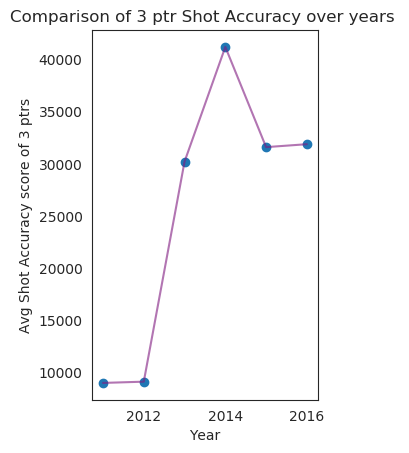

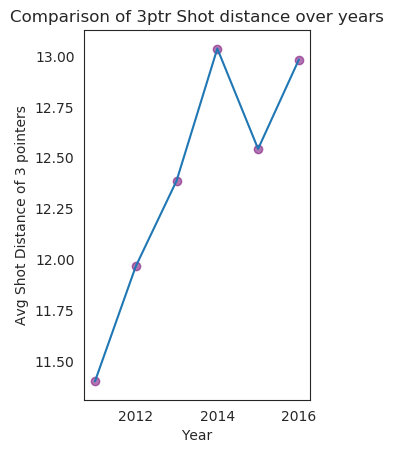

In [410]:
#Plotting shot accuracy wrt year.
plt.subplot(1,2,1)
plt.scatter(year, avg_shot_acc_by_year) 
plt.plot(year, avg_shot_acc_by_year,color = (0.5,0.1,0.5,0.6))
plt.xlabel('Year')
plt.ylabel('Avg Shot Accuracy score of 3 ptrs')
plt.title('Comparison of 3 ptr Shot Accuracy over years ')
plt.show() 

plt.subplot(1, 2, 2)
plt.scatter(year, avg_shot_dist_by_year,color = (0.5,0.1,0.5,0.6)) 
plt.plot(year, avg_shot_dist_by_year)
plt.xlabel('Year')
plt.ylabel('Avg Shot Distance of 3 pointers')
plt.title('Comparison of 3ptr Shot distance over years')
plt.show() 

Hence, comparing both the above graphs, it is evident that the trend in 3 pointer game brought in the increase in accuracy. 
Along with it, the players have used the strategy to shoot 3 pointers from a longer distance as course of their game plan.